In [1]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

fatal: destination path 'lag-llama' already exists and is not an empty directory.


In [2]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir "data/lag-llama"

data/lag-llama/lag-llama.ckpt


In [3]:
!pip install -r lag-llama/requirements.txt --quiet

In [4]:
import sys

sys.path.append('lag-llama')
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd
import os
from lag_llama.gluon.estimator import LagLlamaEstimator

/Users/aclicona/Documents/Python/Monografia/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [5]:
def get_lag_llama_predictions(dataset, prediction_length, device, context_length=32, use_rope_scaling=False, num_samples=100):
    ckpt = torch.load("data/lag-llama/lag-llama.ckpt", map_location=device) # Uses GPU since in this Colab we use a GPU.
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="data/lag-llama/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

In [6]:

df_station = pd.read_feather(os.path.join('data', 'dataset.feather'))
df_station

,timestamp,GHI,toa,wind_dir,humidity,precipitation,air_temp,wind_sp,sun_elev,sun_azim,day_of_year,total_minutes_day,attenuation_index
0,2002-01-01 00:00:00,0.0,0.0,142.80,81.81,0.0,8.67,2.27,-71.62,345.99,1,0,0.0
1,2002-01-01 00:30:00,0.0,0.0,142.80,81.81,0.0,8.67,2.27,-71.92,8.14,1,30,0.0
2,2002-01-01 01:00:00,0.0,0.0,147.96,82.59,0.0,8.54,2.37,-70.11,28.73,1,60,0.0
3,2002-01-01 01:30:00,0.0,0.0,153.16,82.90,0.0,8.60,2.29,-66.69,45.10,1,90,0.0
4,2002-01-01 02:00:00,0.0,0.0,156.67,83.40,0.0,8.49,1.52,-62.26,57.44,1,120,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
157771,2010-12-31 21:30:00,0.0,0.0,167.18,88.50,0.0,5.78,2.95,-50.47,283.73,365,1290,0.0
157772,2010-12-31 22:00:00,0.0,0.0,172.75,88.10,0.0,5.82,2.51,-55.87,290.91,365,1320,0.0
157773,2010-12-31 22:30:00,0.0,0.0,169.03,89.59,0.0,5.23,1.97,-60.99,299.78,365,1350,0.0
157774,2010-12-31 23:00:00,0.0,0.0,174.85,90.69,0.0,4.78,2.09,-65.61,311.24,365,1380,0.0


In [7]:
df_station.set_index('timestamp', inplace=True)
df_station['item_id'] = 'AV01'
# Set numerical columns as float32
for col in df_station.columns:
    # Check if column is not of string type
    if df_station[col].dtype != 'object' and pd.api.types.is_string_dtype(df_station[col]) == False:
        df_station[col] = df_station[col].astype('float32')

# Create the Pandas
dataset = PandasDataset.from_long_dataframe(df_station, target="GHI", item_id="item_id")

prediction_length = 48  # Define your prediction length. We use 24 here since the data is of hourly frequency
num_samples = 100 # number of samples sampled from the probability distribution for each timestep
device = torch.device("cpu") # You can switch this to CPU or other GPUs if you'd like, depending on your environment
# device = torch.device("cuda:0") # You can switch this to CPU or other GPUs if you'd like, depending on your environment

In [8]:
forecasts, tss = get_lag_llama_predictions(dataset, prediction_length, device, num_samples)

In [9]:
print(type(forecasts[0]))

<class 'gluonts.model.forecast.SampleForecast'>


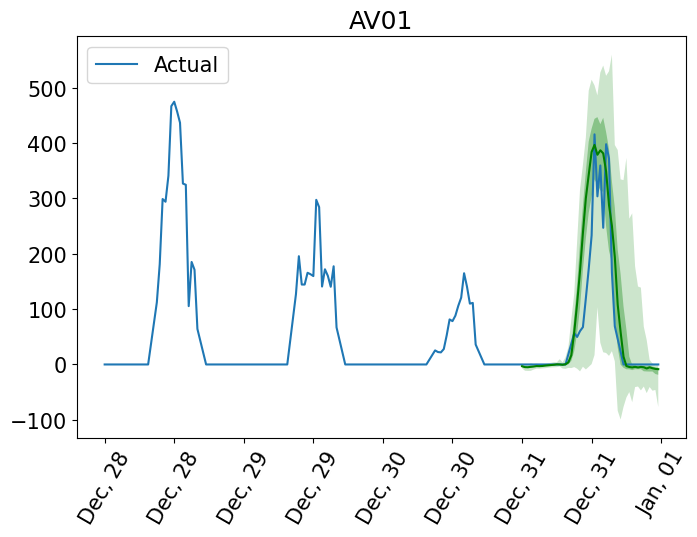

In [10]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 1):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="Actual", )
    forecast.plot(color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [11]:
evaluator = Evaluator()

In [12]:
evaluator(tss, forecasts)

Running evaluation: 1it [00:00, 10.95it/s]
/Users/aclicona/Documents/Python/Monografia/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


({'MSE': 3515.0862630208335,
  'abs_error': 1692.104736328125,
  'abs_target_sum': 3214.0400390625,
  'abs_target_mean': 66.95916748046875,
  'seasonal_error': 52.11915905631659,
  'MASE': 0.6763766462299345,
  'MAPE': 0.8716567190069902,
  'sMAPE': 1.4402734438578289,
  'MSIS': 5.6365221151361915,
  'num_masked_target_values': 0.0,
  'QuantileLoss[0.1]': 421.155588388443,
  'Coverage[0.1]': 0.0,
  'QuantileLoss[0.2]': 940.3508255004883,
  'Coverage[0.2]': 0.16666666666666666,
  'QuantileLoss[0.3]': 1413.2891150832174,
  'Coverage[0.3]': 0.20833333333333334,
  'QuantileLoss[0.4]': 1575.6186830848455,
  'Coverage[0.4]': 0.2916666666666667,
  'QuantileLoss[0.5]': 1692.104838072788,
  'Coverage[0.5]': 0.3541666666666667,
  'QuantileLoss[0.6]': 1590.65587239638,
  'Coverage[0.6]': 0.4166666666666667,
  'QuantileLoss[0.7]': 1400.9487911611798,
  'Coverage[0.7]': 0.5208333333333334,
  'QuantileLoss[0.8]': 1231.1599656581875,
  'Coverage[0.8]': 0.6041666666666666,
  'QuantileLoss[0.9]': 939.5